## Preprocessing and Modeling of Credit Card Fraud Detection
### Imported all required libraries and packages for this section

In [1]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# High-cardinality encoder (fast, memory-safe)
from category_encoders.hashing import HashingEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # (kept for template; we do not have nulls)
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import average_precision_score
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_curve, average_precision_score

### Data Loading and Quick Checks

In [2]:
#data = pd.read_csv('eda_dataset.csv')
data = pd.read_csv('eda_dataset_withdate_time.csv')

In [3]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,tr_year,tr_month,tr_day,tr_hour,tr_minute,age,age_group,tr_day_name,distance_cust_merchant_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1,1,0,0,31,adult,Tuesday,78.60
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1,1,0,0,41,adult,Tuesday,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1,1,0,0,57,senior,Tuesday,108.21
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1,1,0,1,52,senior,Tuesday,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1,1,0,3,33,adult,Tuesday,77.56


In [4]:
# percentage of fraud and no fraud trasaction
print(data['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


highly imbalance dataset with almost 99.5 % nofraud trasaction and 0.5% fraud trasaction

In [5]:
# removing fraud characters from merchant column 
data["merchant"] = data["merchant"].str.replace("^fraud_", "", regex=True)

In [6]:
# as amount column is right skewed so changes in into on logarithmic scale 
data["amt_log"] = np.log1p(data["amt"])

In [7]:
# feature enginnering : separated weekends from tr day 
data["is_weekend"] = (data["tr_day"] >= 5).astype(int)

In [8]:
# feature enginnering : created column for night hours 
data["is_night"] = ((data["tr_hour"] <= 5) | (data["tr_hour"] >= 22)).astype(int)

In [9]:
#Groups by each card (cc_num)
# For each card, uses a 24-hour rolling window based on the column trans_date_trans_time
# Counts transactions in last 24 hours
# Returns a Series aligned to original rows

data["trans_date_trans_time"] = pd.to_datetime(data["trans_date_trans_time"], errors="coerce")
# sorted values according to credut card number and "trans_date_trans_time"
data = data.sort_values(["cc_num", "trans_date_trans_time"])

# found trasaction in last 24 hour per credit card 
data["txns_last_24h"] = (
    data.groupby("cc_num", group_keys=False)
        .apply(lambda g: g.rolling("24h", on="trans_date_trans_time")["trans_date_trans_time"].count())
        .reset_index(level=0, drop=True)
)


C:\Users\patid\AppData\Local\Temp\ipykernel_41624\1325653261.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.rolling("24h", on="trans_date_trans_time")["trans_date_trans_time"].count())


In [10]:
# top 20 credit card trasactions count in 24 hour 
data["txns_last_24h"].sort_values(ascending = False).head(20)

676757     36.0
1036681    36.0
676755     35.0
676756     35.0
676841     35.0
1304769    35.0
1649372    35.0
676842     35.0
1036685    35.0
1036680    35.0
1649374    35.0
1009123    35.0
676753     34.0
1009122    34.0
1304768    34.0
1009124    34.0
676754     34.0
1036679    34.0
1036684    34.0
1304770    34.0
Name: txns_last_24h, dtype: float64

In [11]:
#rolling mean amount + deviation feature
data = data.sort_values(["cc_num", "trans_date_trans_time"])

# Compute the rolling mean transaction amount for each card
# using the last ~20 transactions to capture normal spending behavior.
#Start computing the rolling mean only after at least 3 transactions

data["amt_mean_20"] = (
    data.groupby("cc_num")["amt"]
        .transform(lambda s: s.rolling(window=20, min_periods=3).mean())
)
print(' missing values after rolling window operation',data["amt_mean_20"].isnull().sum())
# Fill missing rolling means (early transactions) with global median
# to avoid null values and keep the feature model-safe.
data["amt_mean_20"] = data["amt_mean_20"].fillna(data["amt"].median())


# Measure how unusual the current transaction amount is
# compared to the card’s recent average spending.
data["amt_vs_mean_ratio"] = data["amt"] / (data["amt_mean_20"] + 1e-6)

print(' top 10 deviation in current trasaction compare to average spending',data["amt_vs_mean_ratio"].sort_values(ascending= False).head(10))

 missing values after rolling window operation 1998
 top 10 deviation in current trasaction compare to average spending 511        34.496733
824        30.211591
1258483    27.919915
1258594    27.670811
1562852    25.372391
913634     25.231401
872619     24.938883
204242     24.456691
64129      23.296522
756940     23.198103
Name: amt_vs_mean_ratio, dtype: float64


In [12]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,age,age_group,tr_day_name,distance_cust_merchant_km,amt_log,is_weekend,is_night,txns_last_24h,amt_mean_20,amt_vs_mean_ratio
1017,2019-01-01 12:47:15,60416207185,"Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Tuesday,127.61,2.112635,0,0,5.0,47.450,0.153214
2724,2019-01-02 08:44:57,60416207185,Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,110.31,3.987872,0,0,7.0,47.450,1.115701
2726,2019-01-02 08:47:36,60416207185,Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,21.79,4.419804,0,0,6.0,47.430,1.730550
2882,2019-01-02 12:38:14,60416207185,Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,87.20,3.577669,0,0,5.0,44.270,0.785859
2907,2019-01-02 13:10:46,60416207185,Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,...,33,adult,Wednesday,74.21,3.338613,0,0,2.0,40.852,0.665328


In [13]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'tr_year', 'tr_month', 'tr_day', 'tr_hour',
       'tr_minute', 'age', 'age_group', 'tr_day_name',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

In [14]:
data.shape

(1852394, 37)

In [15]:
# corelation of numeric features with target variable
data.corr(numeric_only=True)['is_fraud'].sort_values(ascending=False).head(10)

is_fraud             1.000000
amt_mean_20          0.246175
amt                  0.209308
amt_vs_mean_ratio    0.118310
amt_log              0.114310
is_night             0.088690
tr_hour              0.013196
age                  0.010927
tr_day               0.004562
lat                  0.002904
Name: is_fraud, dtype: float64

In [16]:
# unique count values in each categorical variable
data_c = data.select_dtypes(include=['object','category'])
for c in data_c:
    print( c ,':',data_c[c].nunique())

merchant : 693
category : 14
first : 355
last : 486
gender : 2
street : 999
city : 906
state : 51
job : 497
dob : 984
trans_num : 1852394
unix_time : 1819583
age_group : 3
tr_day_name : 7


In [17]:
#unique count values in each numerical variable
data_n = data.select_dtypes(include=['number'])
for c in data_n:
    print( c ,':',data_n[c].nunique())

cc_num : 999
amt : 60616
zip : 985
lat : 983
long : 983
city_pop : 891
merch_lat : 1754157
merch_long : 1809753
is_fraud : 2
tr_year : 2
tr_month : 12
tr_day : 7
tr_hour : 24
tr_minute : 60
age : 83
distance_cust_merchant_km : 14547
amt_log : 60616
is_weekend : 2
is_night : 2
txns_last_24h : 36
amt_mean_20 : 696705
amt_vs_mean_ratio : 1851684


In [18]:

# dropped id types colums with high unique nuerical counts and also dropped high cardibality categorical column

cols_to_drop = [
    "cc_num","trans_num","unix_time","first","last","street",
    "merchant","job","city","zip",
    "trans_date_trans_time","tr_year","tr_minute","tr_day_name",
    "lat","long","merch_lat","merch_long",
    "age_group","dob","amt",
    "tr_day","tr_month"   # drop raw calendar splits to reduce memorization
]

data = data.drop(columns=cols_to_drop, errors="ignore")


In [19]:
data.shape

(1852394, 14)

In [20]:
data.columns

Index(['category', 'gender', 'state', 'city_pop', 'is_fraud', 'tr_hour', 'age',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

### Train/Test Split

In [21]:
# STEP 1: Reduce from 1.8M to 100K while keeping original ratio
data_small, _ = train_test_split(data,train_size=100_000,stratify=data['is_fraud'],random_state=42)

# Check ratio preserved
print(data_small['is_fraud'].value_counts(normalize=True))

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64


after reducing data size fraud rate is maintained 

In [22]:
# STEP 2: Now split data into train and test whike mainting fraud ration in both train and test data

X = data_small.drop(columns=['is_fraud'])
y = data_small['is_fraud']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)
print("Train ratio:", y_train.mean())
print("Test ratio:", y_test.mean())

Train ratio: 0.0052125
Test ratio: 0.0052


In [23]:
X_train

,category,gender,state,city_pop,tr_hour,age,distance_cust_merchant_km,amt_log,is_weekend,is_night,txns_last_24h,amt_mean_20,amt_vs_mean_ratio
10370,misc_pos,F,PA,184,8,74,83.12,2.243896,0,0,3.0,43.4590,0.193976
951816,misc_net,F,PA,1274,3,71,109.39,0.963174,0,1,3.0,52.7165,0.030730
1488483,home,F,SC,2206,15,34,69.56,3.816393,0,0,6.0,51.5440,0.862176
15941,gas_transport,M,MI,95,10,25,82.89,4.258870,0,0,6.0,118.5205,0.588337
1281193,shopping_net,F,MS,4198,15,19,42.45,2.070653,0,0,3.0,71.0560,0.097529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
910656,misc_net,F,NM,310,5,41,88.69,1.932970,1,1,3.0,49.2575,0.119982
1157235,home,M,IL,2092,17,58,70.81,0.959350,0,0,3.0,74.8820,0.021500
1027256,shopping_net,F,NC,12335,21,33,115.08,5.579126,1,0,12.0,74.8380,3.525482
695931,entertainment,F,AL,67082,7,56,49.30,1.985131,0,0,7.0,64.3805,0.097545


In [24]:
print(data_small.shape)

(100000, 14)


In [25]:
data_small.columns

Index(['category', 'gender', 'state', 'city_pop', 'is_fraud', 'tr_hour', 'age',
       'distance_cust_merchant_km', 'amt_log', 'is_weekend', 'is_night',
       'txns_last_24h', 'amt_mean_20', 'amt_vs_mean_ratio'],
      dtype='object')

In [26]:
# Feature and Target Variable Definition
target = "is_fraud"

numeric_base = ['city_pop','tr_hour', 'age', 'distance_cust_merchant_km','amt_log', 'is_weekend', 'is_night', 'txns_last_24h', 'amt_mean_20','amt_vs_mean_ratio']

low_card_cat = ['category', 'gender', 'state']
 
#high_card_cat = [ 'job'] #'merchant', 'city', 'zip'this are redundant columns

In [27]:
# Preprocessing Pipelines for Numeric and Categorical Features
from sklearn.preprocessing import OrdinalEncoder

numeric_tranformer = Pipeline(steps = [('scaler', StandardScaler())])
low_cat_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown ='ignore',sparse_output=False))])


In [28]:
## ColumnTransformer for Non-Tree Models
preprocess_non_tree = ColumnTransformer(transformers = [
    ('num',numeric_tranformer,numeric_base),('low_cat',low_cat_transformer,low_card_cat)], remainder = 'drop')
# keep sin/cos, no scaling
#  remainder = 'drop' :Drop all columns that are not mentioned in the transformers list. and viceversa remainder='passthrough'

### Dummy Model

In [29]:
## dummy model 
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline

dummy_pipe = Pipeline(steps=[
    ("preprocess", preprocess_non_tree),  # same preprocessing as your real model
    ("model", DummyClassifier(strategy="most_frequent", random_state=42))  # always non-fraud
])

dummy_pipe.fit(X_train, y_train)
y_pred_dummy = dummy_pipe.predict(X_test)


In [30]:
y_proba_dummy = dummy_pipe.predict_proba(X_test)[:, 1]
y_proba_dummy

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
# Cv for dummy 
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"pr_auc": "average_precision", "recall": "recall"}

res = cross_validate(
    dummy_pipe, X_train, y_train,
    cv=cv, scoring=scoring,
    return_train_score=True, n_jobs=-1
)

# dummy model is “Most Frequent” → it predicts ALL transactions as non-fraud.
print("Dummy Baseline (Most Frequent)")
print(f"PR_AUC  | Train: {res['train_pr_auc'].mean():.4f} | Val: {res['test_pr_auc'].mean():.4f}")
print(f"RECALL  | Train: {res['train_recall'].mean():.4f} | Val: {res['test_recall'].mean():.4f}")

Dummy Baseline (Most Frequent)
PR_AUC  | Train: 0.0052 | Val: 0.0052
RECALL  | Train: 0.0000 | Val: 0.0000


### Model Training - Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
log_reg = LogisticRegression(
    solver="saga",          # fast solver, supports large data
    penalty="l2",           # prevents overfitting (ridge regularization)
    C=0.1,                  # stronger regularization (smaller C)
    class_weight="balanced",# handle class imbalance (fraud vs non-fraud)
    max_iter=1000,          # ensure convergence
    n_jobs=-1,              # use all CPU cores
    random_state=42         # reproducibility
)

pipe_non_tree = Pipeline(steps=[
    ('preprocess', preprocess_non_tree),
    ('smote', SMOTE(sampling_strategy=0.10, random_state=42,k_neighbors=2)),
    ('model', log_reg)
])
# sampling_strategy=0.10 : Minority class will be increased to 10% of the majority class

recall_score 0.9230769230769231
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     19896
           1       0.07      0.92      0.12       104

    accuracy                           0.93     20000
   macro avg       0.53      0.93      0.54     20000
weighted avg       0.99      0.93      0.96     20000

ROC_AUC: 0.9794754840555503
PR-AUC: 0.267432537246691


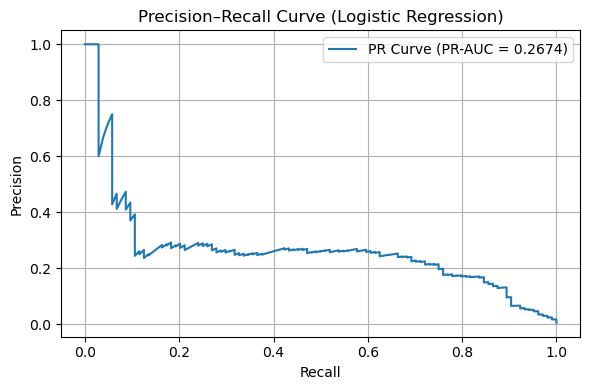

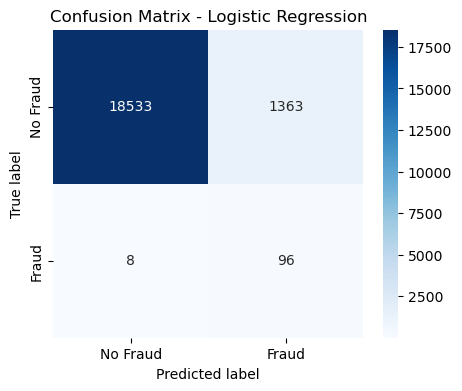

In [33]:
# without grid search cv 
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

pipe_non_tree.fit(X_train, y_train)
# Generate class predictions (0 or 1)
# Used for confusion matrix, recall, precision, and F1-score
y_pred = pipe_non_tree.predict(X_test)
# Generate predicted probabilities for the positive class (fraud = 1)
y_proba = pipe_non_tree.predict_proba(X_test)[:, 1]
# Compute recall score
# Recall is critical in fraud detection as it measures # how many actual fraud cases are correctly identified
print('recall_score', recall_score(y_test, y_pred))
 

#Print detailed classification report
# Includes precision, recall, F1-score, and support
# Helps understand trade-offs between false positives and false negatives
print(classification_report(y_test, y_pred))

#Compute ROC-AUC score
# Evaluates model’s ability to separate fraud vs non-fraud
# Independent of classification threshold
print("ROC_AUC:", roc_auc_score(y_test, y_proba))


# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute PR-AUC
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", pr_auc)
# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR Curve (PR-AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate confusion matrix
# Shows True Positives, False Positives, True Negatives, and False Negatives
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix using heatmap
# Makes error distribution easier to interpret
labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels) #cmap='Reds'
#Label axes for clarity
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#“The model outputs probabilities; the threshold converts probabilities into decisions.”

### Model Training — Tree Models (Decision Tree / Random Forest / XGBoost)

In [34]:
# pipline for tree input
preprocess_tree = ColumnTransformer(
    transformers=[('num', 'passthrough',numeric_base),('low_cat',low_cat_transformer,low_card_cat)],remainder='drop')

### Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
dt = DecisionTreeClassifier(
    criterion="gini",           # measure node purity (default & fast)
    max_depth=3,                # limit tree depth to avoid overfitting
    min_samples_split=10,       # minimum samples needed to split a node
    min_samples_leaf=10,        # minimum samples in a leaf (smooth predictions)
    class_weight="balanced",    # handle class imbalance
    random_state=42             # reproducibility
)

dt_pipe = Pipeline(steps=[('preprocess', preprocess_tree),('model', dt)]) #('smote', SMOTE(sampling_strategy=0.10, random_state=42)),

Decision Tree – classification report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19896
           1       0.09      0.88      0.17       104

    accuracy                           0.96     20000
   macro avg       0.55      0.92      0.57     20000
weighted avg       0.99      0.96      0.97     20000

Confusion matrix
[[19017   879]
 [   12    92]]
ROC_AUC: 0.9698456009712042
Decision Tree PR-AUC: 0.2647834213856895


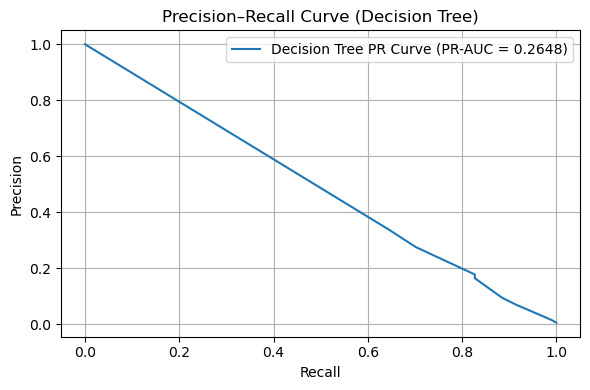

recall_score 0.8846153846153846


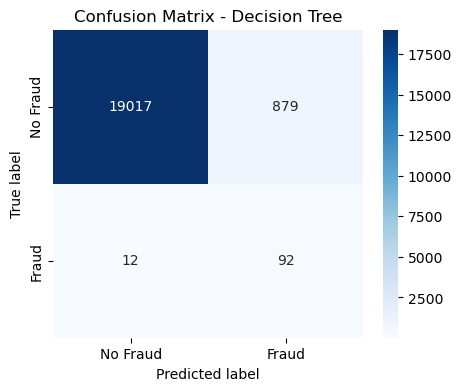

In [36]:
dt_pipe.fit(X_train, y_train)
y_pred_dt  = dt_pipe.predict(X_test)
y_proba_dt = dt_pipe.predict_proba(X_test)[:, 1] 

print("Decision Tree – classification report")
print(classification_report(y_test, y_pred_dt))

print("Confusion matrix")
print(confusion_matrix(y_test, y_pred_dt))

print("ROC_AUC:", roc_auc_score(y_test, y_proba_dt))

# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
# Compute Precision–Recall curve
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, y_proba_dt)
# Compute PR-AUC
pr_auc_dt = average_precision_score(y_test, y_proba_dt)
# Print PR-AUC value
print("Decision Tree PR-AUC:", pr_auc_dt)
# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall_dt,precision_dt,label=f"Decision Tree PR Curve (PR-AUC = {pr_auc_dt:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Decision Tree)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# confusion metrix
print('recall_score', recall_score(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)
labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()



### Random Forest

In [37]:

rf = RandomForestClassifier(
    n_estimators=300,              # number of trees (more = stable, slower)
    max_depth=5,                   # limit tree depth to reduce overfitting
    min_samples_split=20,          # minimum samples to split a node
    min_samples_leaf=10,           # minimum samples per leaf (smooth predictions)
    max_features="sqrt",           # features per split (reduces correlation)
    class_weight="balanced_subsample",  # handle class imbalance per tree
    oob_score=True,                # out-of-bag validation estimate
    n_jobs=-1,                     # use all CPU cores
    random_state=42                # reproducibility
)
#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),('model', rf)])

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19896
           1       0.16      0.88      0.27       104

    accuracy                           0.98     20000
   macro avg       0.58      0.93      0.63     20000
weighted avg       0.99      0.98      0.98     20000

ROC_AUC: 0.986382071386595
Random Forest PR-AUC: 0.7049137401335075


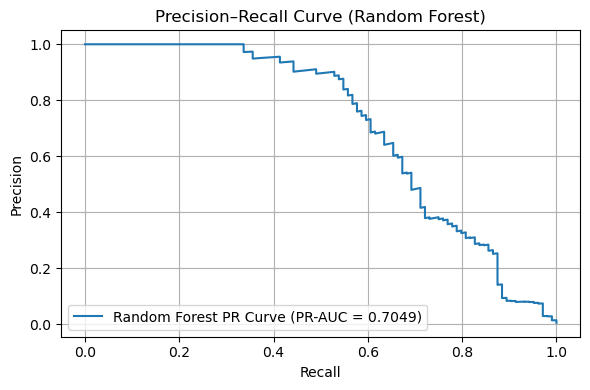

Confusion matrix:
 [[19413   483]
 [   13    91]]
recall_score 0.875


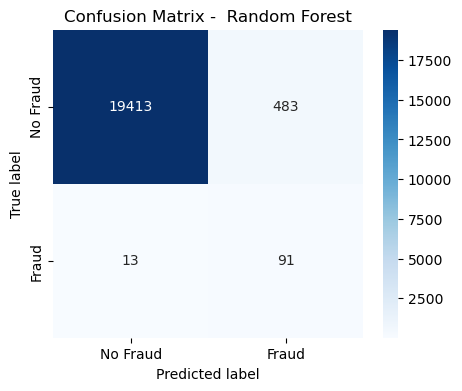

In [38]:
rf_pipe.fit(X_train, y_train)

y_pred_rf  = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_rf))


# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.

# Compute Precision–Recall curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)

# Compute PR-AUC
pr_auc_rf = average_precision_score(y_test, y_proba_rf)
# Print PR-AUC value
print("Random Forest PR-AUC:", pr_auc_rf)
# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall_rf,precision_rf,label=f"Random Forest PR Curve (PR-AUC = {pr_auc_rf:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# confusion metrix
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
# recall
print('recall_score', recall_score(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix -  Random Forest')
plt.show()

In [39]:
#!pip install xgboost

### Xgboost

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19896
           1       0.31      0.94      0.46       104

    accuracy                           0.99     20000
   macro avg       0.65      0.97      0.73     20000
weighted avg       1.00      0.99      0.99     20000

ROC_AUC: 0.9968185526275092
XGBoost PR-AUC: 0.7821172095112715


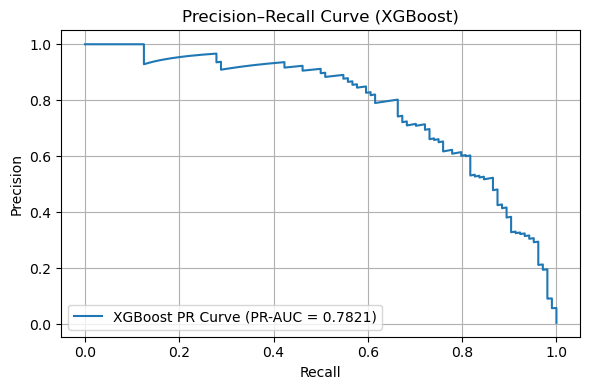

Recall: 0.9423076923076923


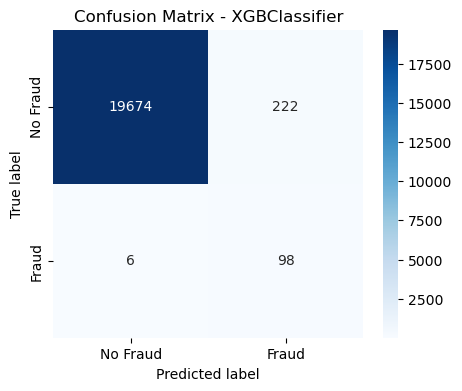

In [40]:

from xgboost import XGBClassifier

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


xgb = XGBClassifier(
    # ---- core ----
    n_estimators=600,          # number of trees (fewer, stronger trees)
    learning_rate=0.05,        # step size; higher LR → fewer trees

    # ---- complexity control ----
    max_depth=2,               # very shallow trees (strong anti-overfit)
    min_child_weight=100,      # avoid learning from tiny / noisy patterns
    gamma=1.5,                 # split only if gain is meaningful

    # ---- randomness ----
    subsample=0.6,             # use 60% rows per tree (regularization)
    colsample_bytree=0.6,      # use 60% features per tree

    # ---- regularization ----
    reg_alpha=10.0,            # L1 regularization (feature sparsity) Sets some Unimportant / noisy features weights exactly to 0 → sparse

    reg_lambda=30.0,           # L2 regularization to shrink weights and reduce overfitting

    # ---- imbalance handling ----
    scale_pos_weight=pos_weight * 0.25,  # control fraud vs non-fraud balance/ # handle class imbalance without over-penalizing fraud

    # ---- misc ----
    tree_method="hist",        # faster histogram-based training
    eval_metric="aucpr",       # optimize PR-AUC (best for fraud)
    random_state=42,           # reproducibility
    n_jobs=-1                  # use all CPU cores
)

#('smote', SMOTE(sampling_strategy=0.10, random_state=42)),
xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocess_tree),  # feature preprocessing for tree-based model
    ('model', xgb)  # XGBoost classifier
])

xgb_pipe.fit(X_train, y_train)

y_pred_xgb = xgb_pipe.predict(X_test)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC_AUC:", roc_auc_score(y_test, y_proba_xgb))

# PR_AUC
# PR-AUC is preferred over ROC-AUC for fraud detection because it evaluates
# precision–recall performance on the minority (fraud) class in imbalanced data.
pr_auc = average_precision_score(y_test, y_proba_xgb)
# Compute Precision–Recall curve
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb)

# Compute PR-AUC
pr_auc_xgb = average_precision_score(y_test, y_proba_xgb)
# Print PR-AUC value
print("XGBoost PR-AUC:", pr_auc_xgb)

# Plot PR curve
plt.figure(figsize=(6, 4))
plt.plot( recall_xgb, precision_xgb, label=f"XGBoost PR Curve (PR-AUC = {pr_auc_xgb:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# recall 
print("Recall:", recall_score(y_test, y_pred_xgb))
# confusion metrix
cm = confusion_matrix(y_test, y_pred_xgb)

labels = ['No Fraud', 'Fraud']
plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - XGBClassifier')
plt.show()

                             feature        gain
8                   num__amt_mean_20  932.155396
4                       num__amt_log  685.913269
6                      num__is_night  657.365967
18        low_cat__category_misc_net  274.378082
9             num__amt_vs_mean_ratio  165.847336
12   low_cat__category_gas_transport  164.449661
1                       num__tr_hour  159.219437
11     low_cat__category_food_dining  117.456604
14     low_cat__category_grocery_pos  115.525589
13     low_cat__category_grocery_net  109.759018
10   low_cat__category_entertainment  104.257965
21    low_cat__category_shopping_net   95.852058
16            low_cat__category_home   91.623749
22    low_cat__category_shopping_pos   87.805191
26                 low_cat__state_TX   82.135345
17       low_cat__category_kids_pets   82.004646
0                      num__city_pop   71.084328
15  low_cat__category_health_fitness   69.609871
19        low_cat__category_misc_pos   64.215965
2                   

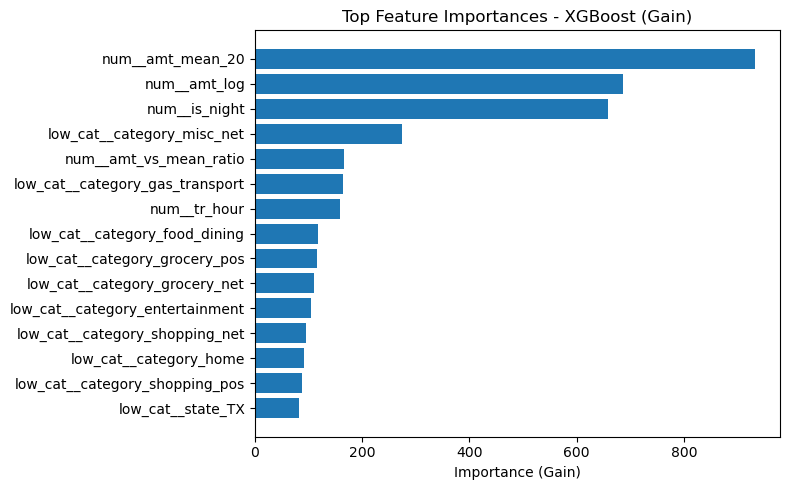

In [41]:

# extract trained XGBoost model from pipeline
xgb_model = xgb_pipe.named_steps["model"]

# get feature names after preprocessing
feature_names = xgb_pipe.named_steps["preprocess"].get_feature_names_out()

# get feature importance based on gain (loss reduction)
score = xgb_model.get_booster().get_score(importance_type="gain")

# map XGBoost feature indices (f0, f1, ...) to actual feature names
imp_df = pd.DataFrame(
    [(feature_names[int(k[1:])], v) for k, v in score.items()],
    columns=["feature", "gain"]
).sort_values("gain", ascending=False)

# display top 20 important features
print(imp_df.head(20))

# plot top 15
top_n = 15
plt.figure(figsize=(8,5))
plt.barh(imp_df.head(top_n)["feature"], imp_df.head(top_n)["gain"])
plt.gca().invert_yaxis()
plt.xlabel("Importance (Gain)")
plt.title("Top Feature Importances - XGBoost (Gain)")
plt.tight_layout()
plt.show()

### Thresold tunning 

In [42]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
threshold = 0.20
# y_pred_lgb  = lgbm_pipe.predict(X_test)
# y_proba_lgb = lgbm_pipe.predict_proba(X_test)[:, 1]

y_pred = (y_proba_xgb >= threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Threshold:", threshold)
print("Fraud Recall (catch rate):", recall_score(y_test, y_pred))
print("Fraud Precision:", precision_score(y_test,y_pred))
print("Fraud F1:", f1_score(y_test, y_pred))
print("TP (fraud caught):", tp)
print("FN (fraud missed):", fn)
print("FP (false alerts):", fp)
print("Alert rate:", (tp+fp)/len(y_test))

Threshold: 0.2
Fraud Recall (catch rate): 0.9807692307692307
Fraud Precision: 0.1471861471861472
Fraud F1: 0.2559598494353827
TP (fraud caught): 102
FN (fraud missed): 2
FP (false alerts): 591
Alert rate: 0.03465


### Cross Validation for all above Models

In [51]:
# Stratified CV keeps fraud/non-fraud ratio same in every fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics: PR-AUC for imbalanced ranking, Recall for catching fraud
scoring = {
    "pr_auc": "average_precision",
    "recall": "recall"}

# Models to evaluate
models_to_check = {
    "LogReg + SMOTE": pipe_non_tree,
    "Decision Tree": dt_pipe,
    "Random Forest": rf_pipe,
    "XGBoost": xgb_pipe}

def cv_report(name, model):
    print("\n" + "=" * 50)
    print(f"CV Report: {name}")

    # Run CV and return train + validation scores for each metric
    res = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    # Compute mean scores across folds
    pr_auc_train_mean = res["train_pr_auc"].mean()
    pr_auc_val_mean   = res["test_pr_auc"].mean()
    recall_train_mean = res["train_recall"].mean()
    recall_val_mean   = res["test_recall"].mean()

    # Print scores
    print(f"PR_AUC  | Train: {pr_auc_train_mean:.4f} | Val: {pr_auc_val_mean:.4f}")
    print(f"RECALL  | Train: {recall_train_mean:.4f} | Val: {recall_val_mean:.4f}")

    # Quick overfit/underfit checks using train–val gap
    pr_auc_gap = pr_auc_train_mean - pr_auc_val_mean
    recall_gap = recall_train_mean - recall_val_mean
    # PR-AUC assessment
    if pr_auc_gap > 0.08:
        print("PR-AUC Assessment: Overfitting")
    elif pr_auc_train_mean < 0.35 and pr_auc_val_mean < 0.30:
        print("PR-AUC Assessment: Underfitting")
    else:
        print("PR-AUC Assessment: Acceptable")

    # Recall assessment
    if recall_gap > 0.08:
        print("Recall Assessment: Overfitting")
    elif recall_val_mean < 0.60:
        print("Recall Assessment: Underfitting")
    else:
        print("Recall Assessment: Acceptable")
# Run CV for all models
for name, model in models_to_check.items():
    try:
        cv_report(name, model)
    except Exception as e:
        print("\n" + "=" * 60)
        print(f"CV failed for {name}")
        print(e)


CV Report: LogReg + SMOTE
PR_AUC  | Train: 0.2075 | Val: 0.2066
RECALL  | Train: 0.9203 | Val: 0.8536
PR-AUC Assessment: Underfitting
Recall Assessment: Acceptable

CV Report: Decision Tree
PR_AUC  | Train: 0.2478 | Val: 0.2411
RECALL  | Train: 0.8759 | Val: 0.8489
PR-AUC Assessment: Underfitting
Recall Assessment: Acceptable

CV Report: Random Forest
PR_AUC  | Train: 0.7340 | Val: 0.6711
RECALL  | Train: 0.8843 | Val: 0.8585
PR-AUC Assessment: Acceptable
Recall Assessment: Acceptable

CV Report: XGBoost
PR_AUC  | Train: 0.7742 | Val: 0.7163
RECALL  | Train: 0.9442 | Val: 0.8705
PR-AUC Assessment: Acceptable
Recall Assessment: Acceptable


In [52]:
# recall value from all models 
recall_dummy = recall_score(y_test, y_pred_dummy)
recall_log_reg   = recall_score(y_test, y_pred)
recall_dt        = recall_score(y_test, y_pred_dt)
recall_rf        = recall_score(y_test, y_pred_rf)
recall_xgb       = recall_score(y_test, y_pred_xgb)


                 model    recall
0         recall_dummy  0.000000
1  Logistic Regression  0.980769
2        Decision Tree  0.884615
3        Random Forest  0.875000
4              XGBoost  0.942308


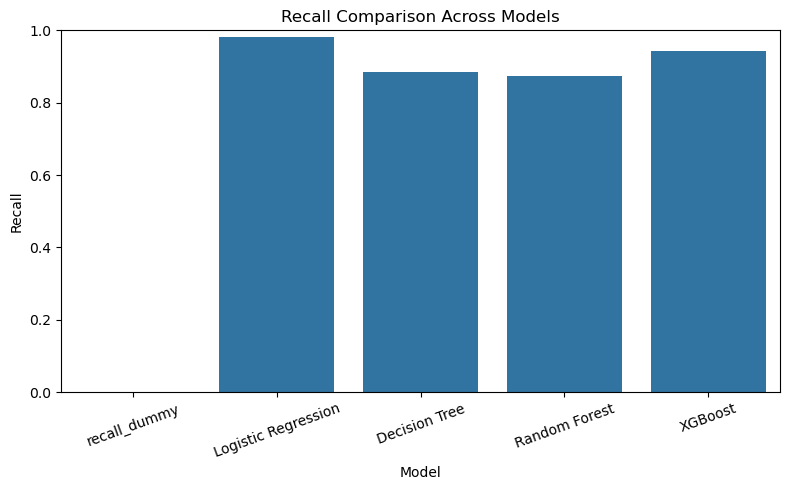

In [53]:
# plotting bar plot for various recall results obtained from various models
recall_data = {"model": ["recall_dummy", "Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "recall": [ recall_dummy,recall_log_reg, recall_dt, recall_rf, recall_xgb]
}

recall_df = pd.DataFrame(recall_data)

print(recall_df)

# bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=recall_df, x="model", y="recall")

plt.ylim(0, 1)  # recall is between 0 and 1
plt.title("Recall Comparison Across Models")
plt.ylabel("Recall")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [54]:
# PR-AUC value from all models 
prauc_dummy = average_precision_score(y_test,y_proba_dummy)
prauc_log_reg = average_precision_score(y_test, y_pred)
prauc_dt      = average_precision_score(y_test, y_proba_dt)
prauc_rf      = average_precision_score(y_test, y_proba_rf)
prauc_xgb     = average_precision_score(y_test, y_proba_xgb)

                 model    pr_auc
0          dummy_model  0.005200
1  Logistic Regression  0.144456
2        Decision Tree  0.264783
3        Random Forest  0.704914
4              XGBoost  0.782117


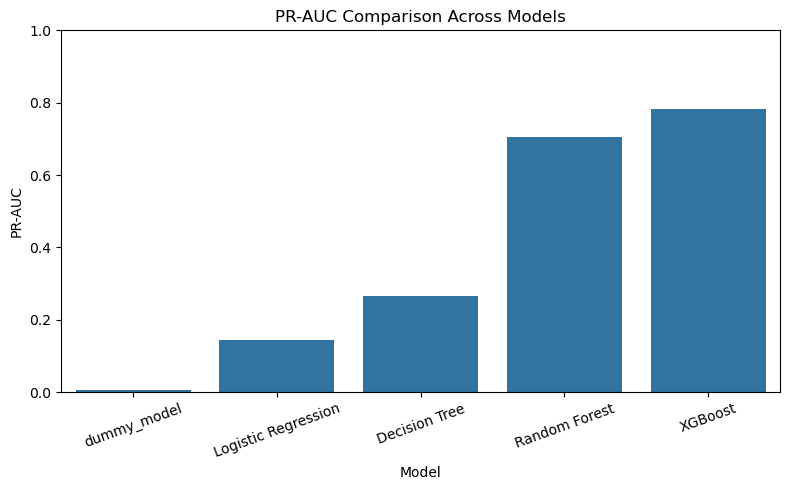

In [55]:
# plotting all PR auc values obtained from various models
prauc_data = {
    "model": ["dummy_model","Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "pr_auc": [prauc_dummy,prauc_log_reg, prauc_dt, prauc_rf, prauc_xgb]
}

prauc_df = pd.DataFrame(prauc_data)
print(prauc_df)
plt.figure(figsize=(8, 5))
sns.barplot(data=prauc_df, x="model", y="pr_auc")

plt.ylim(0, 1)
plt.title("PR-AUC Comparison Across Models")
plt.ylabel("PR-AUC")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [56]:
# creating dataframe from recall and prauc results obtained from cross validation 
cv_results = pd.DataFrame({
    "model": ["dummy_model",
        "Logistic Regression + SMOTE",
        "Decision Tree",
        "Random Forest",
        "XGBoost"
    ],
    "train_recall": [0.0,0.920, 0.876, 0.884, 0.944],
    "val_recall":   [0.0,0.854, 0.849, 0.858, 0.870],
    "train_prauc": [0.0052,0.207, 0.248, 0.734, 0.774],
    "val_prauc":    [0.0052,0.207, 0.241, 0.671, 0.716]
})

cv_results

,model,train_recall,val_recall,train_prauc,val_prauc
0,dummy_model,0.000,0.000,0.0052,0.0052
1,Logistic Regression + SMOTE,0.920,0.854,0.2070,0.2070
2,Decision Tree,0.876,0.849,0.2480,0.2410
3,Random Forest,0.884,0.858,0.7340,0.6710
4,XGBoost,0.944,0.870,0.7740,0.7160


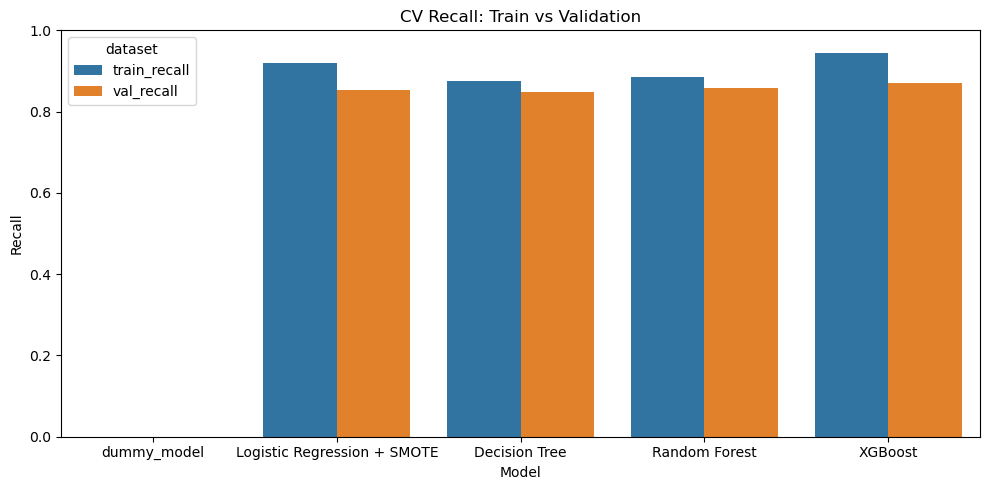

In [57]:
# plotting bar plot of recall value of train and test values obtained from various models   
recall_df = cv_results.melt(
    id_vars="model",
    value_vars=["train_recall", "val_recall"],
    var_name="dataset",
    value_name="recall"
)

plt.figure(figsize=(10,5))
sns.barplot(data=recall_df, x="model", y="recall", hue="dataset")

plt.ylim(0, 1)
plt.title("CV Recall: Train vs Validation")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.legend(title="dataset", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

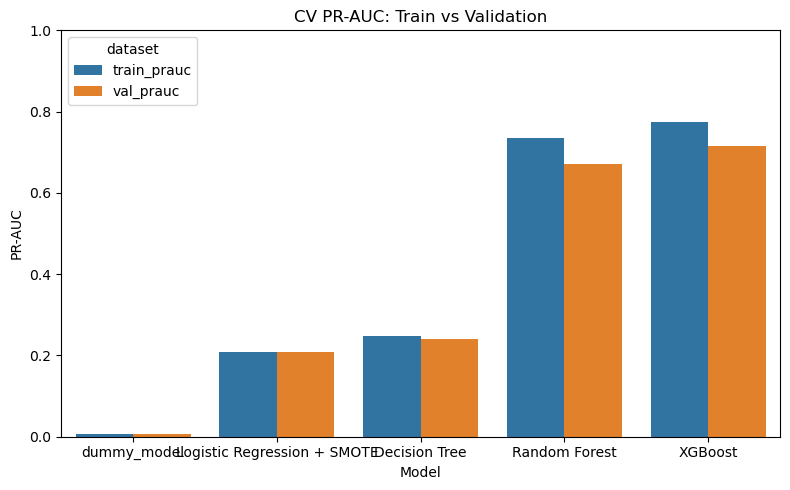

In [58]:
## plotting bar plot of AR-PUC value of train and test values obtained from various models   
prauc_df = cv_results.melt(
    id_vars="model",
    value_vars=["train_prauc", "val_prauc"],
    var_name="dataset",
    value_name="pr_auc"
)

plt.figure(figsize=(8,5))
sns.barplot(data=prauc_df, x="model", y="pr_auc", hue="dataset")

plt.ylim(0, 1)
plt.title("CV PR-AUC: Train vs Validation")
plt.xlabel("Model")
plt.ylabel("PR-AUC")
plt.legend(title="dataset", loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [59]:
# Based on PRAUC and recall final model is XGboost